## Introducing autoencoders
> "An autoencoder is a type of neural network used to learn efficient data  codings in an unsupervised manner."

In other words, the aim of an autoencoder is to learn a lower representation of a set of data, which is useful for feature extraction, dimensionality reduction, and image denoising tasks, among others. Its architecture consists of an encoder, which compresses the input into a latent space representation also known as bottleneck, and a decoder, which reconstructs the input from the latent space representation.

In [15]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [22]:
head_names = ['t','SI','SS','XI','XS','XBH','SNH','SND','XND','TSS','Q','Temp']
df = pd.read_csv('data/DID.csv')
print(df.describe())

scaler = MinMaxScaler(feature_range=(-1, 1))

def scale_function(x):
    print(x.shape)

for name in head_names[1:]:
    print('Processing ', name)
    df[name] = scaler.fit_transform(df[name].values.reshape(-1, 1)).reshape(-1) 
    

                  t            SI            SS            XI            XS  \
count  58465.000000  58465.000000  58465.000000  58465.000000  58465.000000   
mean     304.500000     27.863084     54.097468     91.109417    358.721154   
std      175.807668      5.342176     28.004689     32.921304    128.686638   
min        0.000000      1.991949      0.501940      1.748576     16.080999   
25%      152.250000     25.704825     31.334706     66.728924    261.962091   
50%      304.500000     28.711934     51.660178     93.823651    370.795532   
75%      456.750000     31.250385     73.259125    114.169391    450.003965   
max      609.000000     42.181175    153.969080    199.531913    770.231351   

                XBH           SNH           SND           XND           TSS  \
count  58465.000000  58465.000000  58465.000000  58465.000000  58465.000000   
mean      49.961889     22.632713      5.377474     15.255402    374.844345   
std       18.165266      9.510942      2.305152    

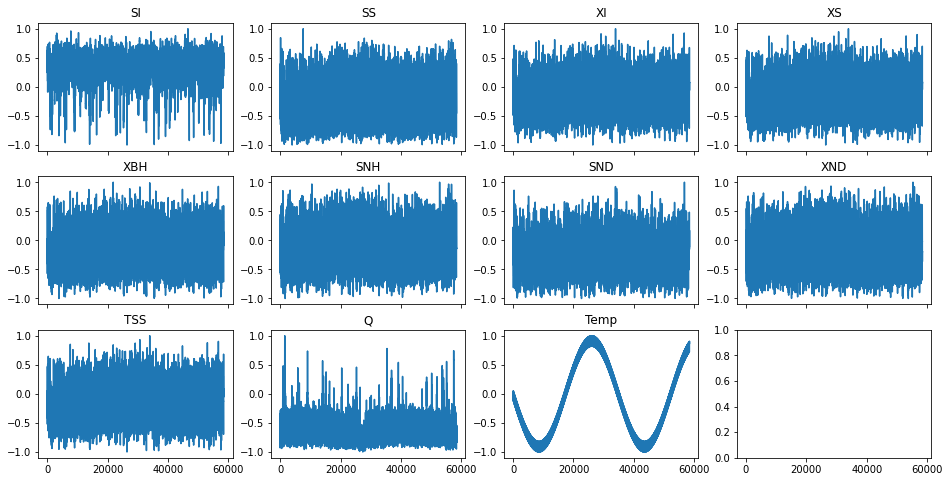

In [23]:
fig, axs = plt.subplots(3,4,figsize=(16,8), sharex=True)
df['SI'].plot(ax=axs[0,0], title='SI')
df['SS'].plot(ax=axs[0,1], title='SS')
df['XI'].plot(ax=axs[0,2], title='XI')
df['XS'].plot(ax=axs[0,3], title='XS')
df['XBH'].plot(ax=axs[1,0], title='XBH')
df['SNH'].plot(ax=axs[1,1], title='SNH')
df['SND'].plot(ax=axs[1,2], title='SND')
df['XND'].plot(ax=axs[1,3], title='XND')
df['TSS'].plot(ax=axs[2,0], title='TSS')
df['Q'].plot(ax=axs[2,1], title='Q')
df['Temp'].plot(ax=axs[2,2], title='Temp')
plt.show()

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import mean_squared_error

In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_ts, in_ch, out_dim, p=0.0):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(in_ts,  32, 1, dropout=0.3)
        self.lstm2 = nn.LSTM(32, 32, 1, dropout=0.4)
        self.fc1   = nn.Linear(in_ch*32, out_dim)
        self.drop1 = nn.Dropout(p=p//2)

    def forward(self,x):
        x = F.tanh(self.lstm1(x)[0])
        x = F.tanh(self.lstm2(x)[0])
        x = torch.flatten(x, 1)
        x = self.drop1(x)
        x = self.fc1(x)
        return x

In [ ]:
class AE1D(nn.Module):
    def __init__(self, in_ch, out_dim):
        super().__init__()
        self.conv1  = nn.Conv1d(in_ch , 16, 3, padding=1)
        self.conv2  = nn.Conv1d(16, 32, 3, padding=1)
        self.pool   = nn.MaxPool1d(2, 2)
        self.tconv1 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.tconv2 = nn.ConvTranspose1d(16, out_dim , 2, stride=2)
        self.conv3  = nn.Conv2d(1, 1, 3)
     
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = self.conv3(x)
        return x

---
## Loading the dataset

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

In [ ]:
input_window = 100

def get_data():
    # construct a littel toy dataset
    time        = np.arange(0, 400, 0.1)    
    #loading weather data from a file
    series = df['SI'].values()
    print(series.shape)
    
    sampels = 
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack? -> din't think this through, looks like the last n sequences are to short, so I just remove them. Hackety Hack.. 

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    # 1 is feature size
    inputs = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) 
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return inputs, target


---
## Building the neural network architecture

As mentioned above, an autoencoder consists of an encoder and a decoder. Despite the possibility of using fully connected layers after flattening the input image, we can use convolutional or recurrent layers for both the encoder and decoder.

In [ ]:
model_lstm   = md.LSTM(in_ts=150, in_ch=8, out_dim=8, p=0.5)
print(model_lstm)
model_ae1d   = md.AE1D(in_ch=6, out_dim=6)
print(model_ae1d)

---
## Training the neural network

For training the neural network, you can run the following code. Apart from training and evaluating the validation set, it will also save a log file that can be afterwards loaded for evaluation.

In [ ]:
optimizer.zero_grad()
# forward + backward + optimize
outputs = model(inputs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
# print statistics
_, pred = torch.max(outputs, 1)
correct = (pred == labels).float().sum().item()
tr_running_loss += loss.item()
tr_running_acc  += (correct/batch_size)

In [ ]:
model.eval()
outputs = model(inputs)